### deep_dreaming with tf

>[Loading and displaying the model graph](#loading)

>[Classifying Images](#classify)

>[Naive feature visualization](#naive)

>[Multiscale image generation](#multiscale)

>[Laplacian Pyramid Gradient Normalization](#laplacian)

>[Playing with feature visualizations](#playing)

>[DeepDream](#deepdream)

>[More Fun](#fun)

### this tutorial will show how to work with tensorflow, and how to use image classification models.
You will benifit most from this if you have somw working knowledge of python, and if you have a rough idea what a neural wntwork is and how it works.

You will learn about deep neural networks, in particular convolutional neural netowrks, and how they are uesed for image classification tasks. We will also gain an intuitive understanding how neural represent information they have learned.

Specifically, you will learn how to:

- Load and pre-trained TensorFlow model and inspect it.
- Classify images using TensorFlow using a pre-trained model.
- Visualize feature channel from a convolutional network to understand what it has learned.
- Enhance what the network sees in a given image to produce dream-like images.

The network we'll examine is [Inception-v3](http://arxiv.org/abs/1512.00567). It's trained to classify an image into 1 of the 1000 categories from the [ImageNet](http://image-net.org) dataset. For a good introduction to neural networks, see the book [Neural Networks and Deep Learning](http://neuralnetworksanddeepleaning.com/) by Michael Nielsen. For background on convolutional networks, see Chris Olah's excellent [blog post](http://colar.github.io/posts/2014-07-Conv-Nets-Modular/).

As discussed in [Inceptionism: Going Deeper into Neural Networks](http://googlesearch.blogspot.com/2015/06/inceptionism-going-deeper-into-neural.html), out goal is to visualize the internal image representations learned by a network trained to classify images. We'll make these visualizations both efficient to generate, and even beautiful.

Impatient readers can start with exploring the full galleries of images generated by the method described here for [GoogLeNet](http://storage.googleapis.com/deepdream/visualz/tensorflow-inception/index.html) and [VGG16](http://storage.googleapis.com/deepdream/visualz/vgg16/index.htnl) architectures.

In [27]:
# boilerplate code
import os
import re
import codecs
from io import StringIO, BytesIO
import numpy as np
from functools import partial
import PIL.Image
import PIL.ImageOps
from IPython.display import clear_output, Image, display, HTML

import tensorflow as tf

print('Done')

Done


*Note: If you are using getting an import error with PIL, you will need install Pillow, via:*

```
sudo pip install Pillow
```

*This is required of the current Docker image as well.*

<a id='loading'></a>
### loading and displaying the model graph

The pretrained network can be downloaded [here](http://downlaod.tensorflow.org/models/inception5h.zip). If it is not already here, download it and unpack the archieve. The actual network is stored in the file `tensorflow_inception_graph.pb`. Set the `model_fn` variable to its path.

We will not load the netowrk and prepare it for input. TensorFlow maintains a computation graph and a session, which maintains state for running computations and which acan be executed remotely. We will first make a fresh graph and a session which uses that graph. The session will beuseed in the rest of the tutorial.

We then load the model. The model consists of a computation graph which happens to have a node called "input", into which we need to feed a batch of input images. The input node in the graph expects images that are normalized by subtractnig the average brightness of all images in the imagenet dataset.

Because we will use singel, unnormalized images, we will make a small graph tha ttakes an image, subtracts the imagenet mean, and expands it th look like a batch of images.

We then load the graph from file and import it into the default graph for our session. The little importer graph is now connected to the input node in the loaded graph, and we can feed regular images into graph.

In [28]:
# creating fresh Graph and TensorFlow session
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)

# prepare input for the format expected by the graph
t_input = tf.placeholder(np.float32, name='our_input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input - imagenet_mean, 0)

# load graph and import into graph used by our session
model_fn = 'imagenet/tensorflow_inception_graph.pb'
# grapf_def = tf.GraphDef.FromString(open(model_fn, 'r', encoding = 'utf-8').read())
graph_def = tf.GraphDef.FromString(open(model_fn, mode='rb').read())
tf.import_graph_def(graph_def, {'input': t_preprocessed})

print("imported")

imported


Let's first count how many layers there are in this graph (we'll only count the convolutional layers), and how many totla features this graph uses internally. We'll look at what those deatures look like later, we have enough to choose from.

In [29]:
layers = [op.name for op in graph.get_operations()
         if op.type == 'Conv2D' and 'import/' in op.name
         ]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

Number of layers 59
Total number of feature channels: 7548


Now we'll look at what the graph looks like. We use tensorboard to visuallize the graph, first stripping large constants (containing the pre-trained network weights) to speed things up. We can use the names shown in the diagram to identify layers we'd like to look into. Be sure to expand the "mixed" node, which containes the bulk of the graph.

In [30]:
# helper functions for TF Graph Visualization
def strip_consts(graph_def, max_const_size = 32):
    """Strip large constant values from graph_def"""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add()
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("\"<stripped %d bytes>\""%size)
    return strip_def;

def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add()
        n.MergeFrom(n0)
        n.name = rename_func(n.name);
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def

def show_graph(graph_def, max_const_size = 32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
        
    strip_def = strip_consts(graph_def, max_const_size = max_const_size)
    
    code = """
        <script>
            function load() {{
                document.getElementById("{id}").pbtxt = {data};
            }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load() >
        <div style="height:600px">
            <tf-graph-basic id = "{id}"></tf_graph_basic>
        </div>
    """.format(data = repr(str(strip_def)), id = 'graph' + str(np.random.rand()))
    
    iframe = """
       <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}">
       </iframe>
    """.format(code.replace('"', '&quote;'))

    print(iframe);

    display(HTML(iframe))
               
# visualizing the network graph. be sure expand the 'mixed' nodes to see their internal
# structure. We are going to visualize 'Conv2D' nodes
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)


       <iframe seamless style="width:800px;height:620px;border:0" srcdoc="
        <script>
            function load() {
                document.getElementById(&quote;graph0.8398805727765192&quote;).pbtxt = 'node {\n  name: &quote;input&quote;\n  op: &quote;Placeholder&quote;\n  device: &quote;/cpu:0&quote;\n  attr {\n    key: &quote;dtype&quote;\n    value {\n      type: DT_FLOAT\n    }\n  }\n  attr {\n    key: &quote;shape&quote;\n    value {\n      shape {\n      }\n    }\n  }\n}\nnode {\n  name: &quote;conv2d0/w&quote;\n  op: &quote;Const&quote;\n  device: &quote;/cpu:0&quote;\n  attr {\n    key: &quote;dtype&quote;\n    value {\n      type: DT_FLOAT\n    }\n  }\n  attr {\n    key: &quote;value&quote;\n    value {\n      tensor {\n        dtype: DT_FLOAT\n        tensor_shape {\n          dim {\n            size: 7\n          }\n          dim {\n            size: 7\n          }\n          dim {\n            size: 3\n          }\n          dim {\n            size: 64\n          }

To make a glimpse into the kinds of patterns that the network learned to recongnize, we will try to generate images that maximize the sum of activations of particular channel of a particular convolutional layer of the neural network. The network we explore contains many convolutional layers, each of which outputs tens to hundreds of feature channels, so we have plenty of patterns to explore.

### classfying images
Let's first classify some images using this graph. The softmax lauer contains the network's predictions in form of numerical IDs. To translate those to human-readable values, we have to load some translation files.

In [33]:
label_lookup_path = 'imagenet/imagenet_2012_challenge_label_map_proto.pbtxt'
uid_lookup_path = 'imagenet/imagenet_synset_to_human_label_map.txt'

# the id translation goes via id strings -- find translation between UID string and
# human friendly names
proto_as_ascii_lines = open(uid_lookup_path).readlines()
uid_to_human = {}
p = re.compile(r'[n\d]*[ \S,]*')
for line in proto_as_ascii_lines:
    parsed_items = p.findall(line)
    uid = parsed_items[0]
    human_string = parsed_items[2]
    uid_to_human[uid] = human_string
    
# get node IDs to UID string map
proto_as_ascii_lines = open(label_lookup_path).readlines()
node_id_to_uid = {}
for line in proto_as_ascii_lines:
    if line.startswith('  target_class:'):
        target_class = int(line.split(': ')[1])
    if line.startswith('  target_class_string:'):
        target_class_string = line.split(': ')[1]
        node_id_to_uid[target_class] = target_class_string[1:-2]

# make node ID to human friendly names map
node_id_to_name = {}
for key, val in node_id_to_uid.items():
    name = uid_to_human[val]
    node_id_to_name[key] = name
    
# make sure we have a name for each possible ID
for i in range(graph.get_tensor_by_name('import/softmax2:0').get_shape()[1]):
    if i not in node_id_to_name:
        node_id_to_name[i] = '???'

Now, you can find out what any neuron stans for. Imagenet has 1000 different classes, some of them pretty obscure.

In [34]:
node_id_to_name[438]

'European gallinule, Porphyrio porphyrio'

The predictions of the network are containe din the outut of the sogrmax layer. Inthe network we loaded, the relevant layer is called "softmax2". We'll make a small function which feeds an input image, reads the result from the graph and trasnlates it, plus an additional function aht awill create an image from an array.

In [45]:
# helper function to get a named layer from the graph
def T(layer_name):
    return graph.get_tensor_by_name('import/%s:0' % layer_name)

softmax = T('softmax2')

def prep_img(filename):
    ''' Load, resize, and central square crop the image. '''
    size = (224, 224)
    img = PIL.Image.open(filename)
    img.thumbnail(size, PIL.Image.ANTIALIAS)
    thumb = PIL.ImageOps.fit(img, size, PIL.Image.ANTIALIAS, 0,(0.5, 0.5))
    return np.float32(thumb)

# print the 5 top predictions for a given image
def prediction(filename, k=5):
    img = prep_img(filename)
    
    # compute predictions
    predictions = sess.run(softmax, {t_input: img})
    predictions = np.squeeze(predictions)
    
    top_k = predictions.argsort()[-k:][::-1]
    for node_id in top_k:
        human_string = node_id_to_name[node_id]
        score = predictions[node_id]
        print("%s (score = %.5f)"%(human_string, score))
        
# helper function: display an image
def showarray(a, fmt='jpeg', size=None):
    a = np.uint8(np.clip(a, 0, 1) * 255)
    f = BytesIO()
    img = PIL.Image.fromarray(a)
    if size is not None:
        img = img.resize((size, size))
    img.save(f, fmt)
    display(Image(data = f.getvalue()))
    
print('defined')

defined


Now we can classify a panda. You should also try other images.

In [ ]:
showarray(prep_img('testimages/deer.jpg')/255., size=500)
prediction('testimages/deer.jpg')

### naive feature visualization
This tells us what the network thinks is contained in an image, but still don't knwon why. So let's start to look at the network has learned to recognize.

First we'll define some helper functions to show images, and an input image with a bit of random noise, which is always useful.

In [48]:
# normalize an image for visualization
def visstd(a, s=0.1):
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

img_noise = np.random.uniform(size = (224,224,3)) + 100.0

The first layer operates directly on the image. It contains a weight tensor taking a 7x7 patch of the image and computing 64 features from it. We can look at the learned wieghts in this layer to see waht kinds of features these are.

conv2d0_w
conv2d1_w
conv2d2_w
mixed3a_1x1_w
mixed3a_3x3_bottleneck_w
mixed3a_3x3_w
mixed3a_5x5_bottleneck_w
mixed3a_5x5_w
mixed3a_pool_reduce_w
mixed3b_1x1_w
mixed3b_3x3_bottleneck_w
mixed3b_3x3_w
mixed3b_5x5_bottleneck_w
mixed3b_5x5_w
mixed3b_pool_reduce_w
mixed4a_1x1_w
mixed4a_3x3_bottleneck_w
mixed4a_3x3_w
mixed4a_5x5_bottleneck_w
mixed4a_5x5_w
mixed4a_pool_reduce_w
mixed4b_1x1_w
mixed4b_3x3_bottleneck_w
mixed4b_3x3_w
mixed4b_5x5_bottleneck_w
mixed4b_5x5_w
mixed4b_pool_reduce_w
mixed4c_1x1_w
mixed4c_3x3_bottleneck_w
mixed4c_3x3_w
mixed4c_5x5_bottleneck_w
mixed4c_5x5_w
mixed4c_pool_reduce_w
mixed4d_1x1_w
mixed4d_3x3_bottleneck_w
mixed4d_3x3_w
mixed4d_5x5_bottleneck_w
mixed4d_5x5_w
mixed4d_pool_reduce_w
mixed4e_1x1_w
mixed4e_3x3_bottleneck_w
mixed4e_3x3_w
mixed4e_5x5_bottleneck_w
mixed4e_5x5_w
mixed4e_pool_reduce_w
mixed5a_1x1_w
mixed5a_3x3_bottleneck_w
mixed5a_3x3_w
mixed5a_5x5_bottleneck_w
mixed5a_5x5_w
mixed5a_pool_reduce_w
mixed5b_1x1_w
mixed5b_3x3_bottleneck_w
mixed5b_3x3_w
mixed

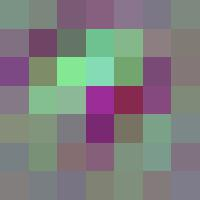

In [50]:
# uncomment the following line to see all the possible weights.
print('\n'.join([op.name[7:] for op in graph.get_operations() if op.name.endswith('w')]))
w = T('conv2d0_w')
shape = w.get_shape().as_list()
print(shape)
feature_id = 14
weights = tf.squeeze(tf.slice(w, [0,0, 0, feature_id], [-1, -1, -1, 1])).eval()
showarray(visstd(weights), size=200)

If you're trained to look at filter kernels, this may be useful to you. Tou can also look at waht the output of the convolution looks like, by running the first layer on an image.

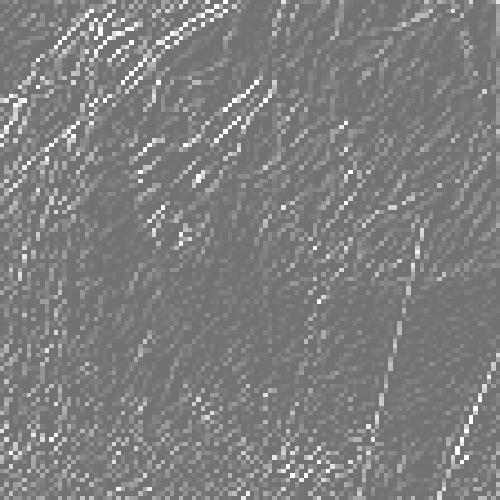

In [52]:
a = T('conv2d0')
feature = tf.squeeze(tf.slice(a, [0, 0 ,0, feature_id], [-1, -1, -1, 1]))
img = prep_img('testimages/deer.jpg')
feature = sess.run(feature, {t_input: img})
showarray(visstd(feature), size = 500)

Even in the first layer, the weights are not easy to interpret. For all layers except the first, it is almost impossible. We have to find another way of understanding what the network has learned.

We use a simple visualization technique to show what any giben feature looks like: Image space gradient ascent. This works as follows: We pick a feature plane froma any layer int he network. This feature plane recognizes the presence of a specific feature in the image. We will try to generate an image tha tmaximizes this feature signal, Ww start with an image that is just noise, and compute the ggradient of the feature signal (averaged over the whole image) with respect to the input image. We then modify the input image to invrease the feature signal. This generates an image tha tthis specific network layer thinks is full of whatever feature it is meant to detect.

In [57]:
def render_naive(t_obj, img0=img_noise, iter_n =20, step = 1.0):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0]
    
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {t_input: img})
        # normalize the gradient, so the same step size should work for different layers and networks
        g /= g.std() + 1e-8
        img += g*step
        print(score)
    clear_output()
    showarray(visstd(img), size=448)

Now we have th pick a layer and a feature channel to visualize. The following cell will enumerate all the available layers. Refer to the graph above to see where they are.

Early layers (closer to the bottom, i.t. the input) have lower level features, later layers have higher level features. Note that we use layer outputs before applying the ReLU nonlinearlity in order to have non-zero gradients for features with negative initial activations (hence the 'pre_relu').

In [58]:
# run this cell if you'd like a list of all layers to pick from
print('\n'.join([op.name[7:] for op in graph.get_operations() if op.name.endswith('pre_relu')]))

conv2d0_pre_relu
conv2d1_pre_relu
conv2d2_pre_relu
mixed3a_1x1_pre_relu
mixed3a_3x3_bottleneck_pre_relu
mixed3a_3x3_pre_relu
mixed3a_5x5_bottleneck_pre_relu
mixed3a_5x5_pre_relu
mixed3a_pool_reduce_pre_relu
mixed3b_1x1_pre_relu
mixed3b_3x3_bottleneck_pre_relu
mixed3b_3x3_pre_relu
mixed3b_5x5_bottleneck_pre_relu
mixed3b_5x5_pre_relu
mixed3b_pool_reduce_pre_relu
mixed4a_1x1_pre_relu
mixed4a_3x3_bottleneck_pre_relu
mixed4a_3x3_pre_relu
mixed4a_5x5_bottleneck_pre_relu
mixed4a_5x5_pre_relu
mixed4a_pool_reduce_pre_relu
mixed4b_1x1_pre_relu
mixed4b_3x3_bottleneck_pre_relu
mixed4b_3x3_pre_relu
mixed4b_5x5_bottleneck_pre_relu
mixed4b_5x5_pre_relu
mixed4b_pool_reduce_pre_relu
mixed4c_1x1_pre_relu
mixed4c_3x3_bottleneck_pre_relu
mixed4c_3x3_pre_relu
mixed4c_5x5_bottleneck_pre_relu
mixed4c_5x5_pre_relu
mixed4c_pool_reduce_pre_relu
mixed4d_1x1_pre_relu
mixed4d_3x3_bottleneck_pre_relu
mixed4d_3x3_pre_relu
mixed4d_5x5_bottleneck_pre_relu
mixed4d_5x5_pre_relu
mixed4d_pool_reduce_pre_relu
mixed4e_1x1_p

### rendering
At this point, we can render one of these layers.

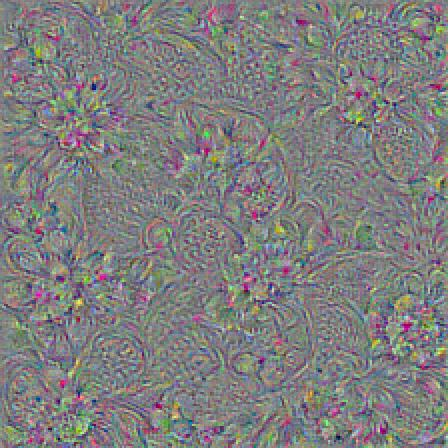

In [59]:
# pick any internal layer.
layer = 'mixed4d_3x3_bottleneck_pre_relu'
print('%d channels in layer.' % T(layer).get_shape()[-1])

# pick a feature channel to visualize
channel = 139

render_naive(T(layer)[:,:,:,channel])

### multiscal image generation
Looks like the network wants to show us something interesting! Let's help it. We are going to apply gradeient ascent on multiple scales. Details formed on smaller scale will be updcaled and augmented with additional details on the next scale.

Basically, instead of starting from a random noise image, we start only the first iteration (octave) from random noise, and each octave after we start from the upsampled result of the previous optimization on the smaller image.

With multiscale image generation it may be tempting to set the number of octaves to some high value to produce wallper-sized image. Storing network activations and backprop values will quickly run out of GPU momory in this case. There is a simple trick to avoid this: split the image into smaller tiles and compute each tile gradient independently. Applying ernadom shifts to the image before every iteration helps avoid tile seams and improves the overall imagel quality.

In [69]:
def tffunc(*argtypes):
    '''
    Helper that transforms TF-graph generating function into a regular one.
    See resize function below.
    '''
    placeholders = map(tf.placeholder, argtypes)
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

# helper function that uses TF to resize an image
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]

resize = tffunc(np.float32, np.int32)(resize)

def calc_grad_tiled(img, t_grad, tile_size =512):
    '''
    compute the value of tensor t_grad ober the image in a tiled way.
    random shifts are applied to the image to blur tile boundaries over multiple iterations.
    '''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sz, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(w-sz//2, sz), sz):
        for x in range(0, max(h-sz//2, sz), sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input: sub})
            grad[y:y+sz, x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

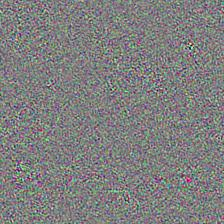

Octave 0


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_9' with dtype int32
	 [[Node: Placeholder_9 = Placeholder[dtype=DT_INT32, shape=<unknown>, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Placeholder_9', defined at:
  File "C:\Users\hjkim\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\hjkim\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-69-51c73640ce50>", line 19, in <module>
    resize = tffunc(np.float32, np.int32)(resize)
  File "<ipython-input-69-51c73640ce50>", line 8, in wrap
    out = f(*placeholders)
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1530, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 1954, in _placeholder
    name=name)
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\hjkim\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_9' with dtype int32
	 [[Node: Placeholder_9 = Placeholder[dtype=DT_INT32, shape=<unknown>, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [70]:
def render_multiscale(t_obj, img0=img_noise, iter_n=10, step=1.0, octave_n=2, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj)
    t_grad = tf.gradients(t_score, t_input)[0]
    
    img = img0.copy()
    for octave in range(octave_n):
        if octave > 0:
            hw = np.float32(img.shape[:2]) * octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            # normalize the gradient, sor the same step size should work for different layers and networks
            g /= g.std() + 1e-8
            img += g*step
            print('.')
        clear_output()
        showarray(visstd(img))
        print('Octave %d' % octave)
        
render_multiscale(T(layer)[:,:,:,channel])